# One-sample Z-test

This notebook will be slightly different from the other notebooks in this repository: here, we will simulate data, whereas in the others, we  use data from the real world.

Z-tests are a family of statistical tests that allow us to ask questions like "Is this sample of data representative of the population, which we assume follows a normal distribution?" Such tests will calculate a statistic (a number) to estimate whether the distribution of the data mimicks what we could be expecting to see in the [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) of the population. For instance, assuming that [the IQ of the general population peaks at 100, with a standard deviation of 15](https://en.wikipedia.org/wiki/IQ_classification), you measure the IQ of your closest friends. Are you and your friends unusually intelligent?

Demonstrating the technique is therefore more easily done when you can create as much or as little data as you want. Particularly, we can specify the mean and standard deviation of the grand population, and we can also draw as much sample data as we want and create all kinds of situations. Because we are the Masters of our "data generation process", we also remove the uncertainty on the fact that there may not be any statistical relationship in the data to begin with.

## The classic one sample z-test

The one-sample Z-test calculates a Z statistic by comparing the mean of the data $\bar{X}$ against that of a population with mean $\mu_0$ and standard deviation $\sigma$, and assumes that there is no difference between the two distributions (the "Null hypothesis").

$$Z = \frac{\bar{X}-\mu_0}{\sigma}$$

This Z-score, as it is sometimes called, is a quantity that represents how the mean should be in relation to a standard deviation, and we can then compare the score we obtained from the distribution of our data to that of what we would obtain in a normal distribution of data. If the scores are different, it means they are drawn from the same population. Alongside tables of such numbers calculated for a normal distribution, you will also find measures of probability that a given score can be found, which would be used to determine a p-value, against an acceptable $\alpha$ level, as it is frequently used in a frequentist null hypothesis significance test.

$$H_0:\bar{X} = \mu_0$$
$$H_1:\bar{X}\neq \mu_0$$

# Bayesian inference
Following on from the quick description of the classic Z-test above its important to keep in mind that Bayesian analysis inference are all derived from the application of Bayes rule

$$P(\theta \mid y) = \frac{P(y \mid \theta) \, P(\theta)}{P(y)}$$

and as such while the following description of the Bayesian model is an equivalent to the Z-test, it is fundamentally different, because its uses fully probabilistic modelling and the infernce is not based on sampling distributions.
    
For a fuller description see the Practicing Bayesian statistics markdown file within the Github repository.

# Steps of Bayesian data analysis

<font size = "3"> Kruschke (2015) offers a step by step formulation for how to conduct a Bayesian analysis:

1. Identify the relevant data for question under investigation.

2. Define the descriptive (mathematical) model for the data.

3. Specify the Priors for the model. If scientific research publication is the goal, the priors must be accepted by a skeptical audience. Much of this can be achieved using prior predcitve checks to ascertain if the priors are reasonable.

4. Using Bayes rule estimate the posterior for the parameters of the model using the likelihood and priors. Then use the posterior for inference.

5. Conduct model checks. i.e. Posterior predcitive checks.</font> 

<font size = "1">This notebook will follow this approach generally.</font> 

#  Step 1 - Identify the relevant data for question under investigation

<font size = "3">The example below is based on simulating and analysing IQ scores. A highly understood phenemomena in the general population, in terms of the standard deviation; due the standardisations of the test with an average IQ set at 100 and standard deviation of 15 (Warne, 2020). In additon to this using IQ data has become standard in Bayesian data analysis teaching (Kruschke, 2015) for pedagogical reasons and as such is used here.</font>

## Simulate the IQ scores

In [2]:
# Import data analysis and visualization packages.
import arviz as az
from cmdstanpy import CmdStanModel, write_stan_json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as stats
import seaborn as sns

#Specify the number of chains to the number of availible cpu's.
n_chains = os.cpu_count()
n_samples = 1000
# Convert to int so Stan will not crash below.
n_warmup = int(n_samples/2)
#Specify step size.
stepS = .8

In [3]:
#from IPython.core.display import HTML as Center

#Center(""" <style>
#.output_png {
#    display: table-cell;
#    text-align: center;
#    vertical-align: middle;
#}
#</style> """)

In [5]:
# Set random seed so the analysis to follow is reproducible.
np.random.seed(1)

# Generating 100 random samples from a normal distribution with mean of 100 and standard deviation of 15, representing 
# IQ scores, that are then analysed below.
IQ = np.round(np.random.normal(loc = 100, scale = 15, size = 100))

## Visualise and explore the data

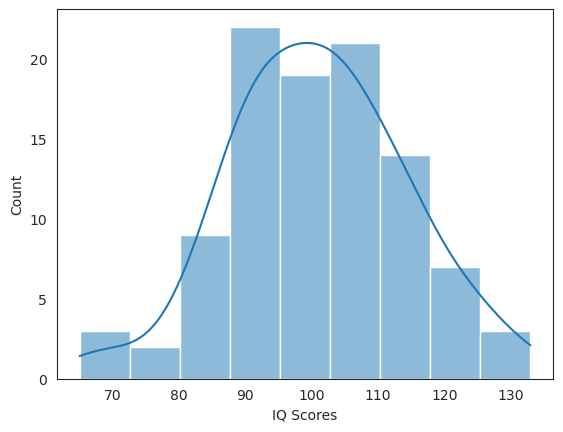

In [6]:
# Set Seaborn theme for data visualisations.
sns.set_style("white");

# Plot  a histogram of the data with a normal distribution imposed.
sns.histplot(IQ, kde= True);
plt.xlabel("IQ Scores");

<font size ="3">From eyeballing the data its looks normally distributed. This of course is unsurprising seeing as it has been randomly generated from a normal distribution. This point is brought up because even though the data visually looks normally distributed it is not a justification for selecting a normal likelihood to model the data. When deciding on how to model the data the likelihood should be based on attempting to model the Data Generating Process (DGP) this of course is unknown, but there is a level of pragmatic choice. As as analyst being open to critisism to your modelling choices can helpful oneto improve your modelling and two ultimately improve the inferences and understanding of the phenomena you are studying.
    
However as this notebook is demonstrating a Bayesian Z-test equivalent a normal likelihood will be used as that is an assumption of the Z-test, and is an assumption of the Bayesian model specified below in section 5, however using full probability models and Bayes rule for our inference allows much greater flexibilty, which will be demonstrated in the other repository notebooks.<font>

# Step 2 - Define the descriptive statistical model 
\begin{align*}

\large y_i &\sim \text{Normal}(\mu, 15) 
\large \mu &\sim \text{Normal}(100, 20)
\end{align*}


<font size = "3">The formulation for presenting statistical models here follows that used by McElreath (2020) for its intuitive nature. In plain english the model specifies that the dependent variable $y_i$ (IQ scores)  is distributed normally in terms of the Likelihood with a known standard deviation of 15 but an unkown $\mu$ that is to be estimated with a normally distributed prior probability  on $\mu$ that has a $ \mu = 100$ and $ \sigma = 20$.</font>

# Step 3 - Specifying priors

## Prior predictive checks

### Visualising priors
The first step in prior predictive check is to visualise the priors within the model for the parameters being modelled.
As the statistical model specified above shows their is only one prior in the analysis and the standard deviation
is assumed to be known at 15 and as such is not estimated and does not need a prior.


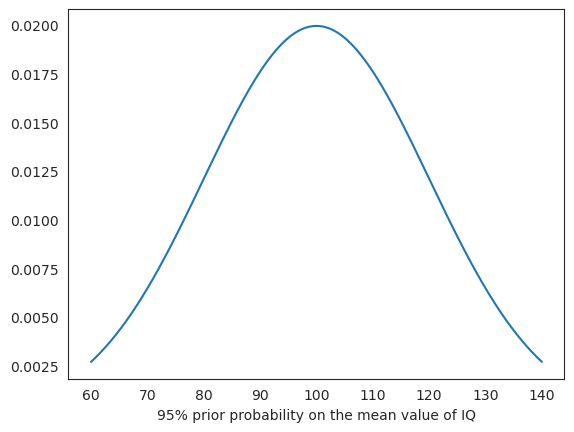

In [7]:
# PLot the prior of the model for describing possible mean values of the DGP for IQ scores. This is quite a broad prior
# and shouldnt be too controversialto a skeptical audience of IQ researchersas it assigns 95% probability of the mean for IQ to be estimated ranging from 
# from 60 and 140.

#Creat range of points to plot the pdf function on
Range_of_X_axis = np.arange(60, 140, 0.001)

#Plot the normal pdf that shows our prior on the means of the probable mean values for IQ
plt.plot(Range_of_X_axis, stats.norm.pdf(Range_of_X_axis, loc = 100, scale = 20));
plt.xlabel("95% prior probability on the mean value of IQ");

<font size =3>Note that that the pdf is cut of at 2 standard deviations above as this is where 95% of the probability mass lies for the probable values of $mu$ and shows how broad the prior is in the case of probable IQ scores, follwing the 68–95–99.7 rule of normal distributions.<\font>

###  Simulating data based on the priors

Following the visualisation of the priors for the parameters of the model to 
check how they interact it is important to run prior predcitive check by 
simulating data based on the model.

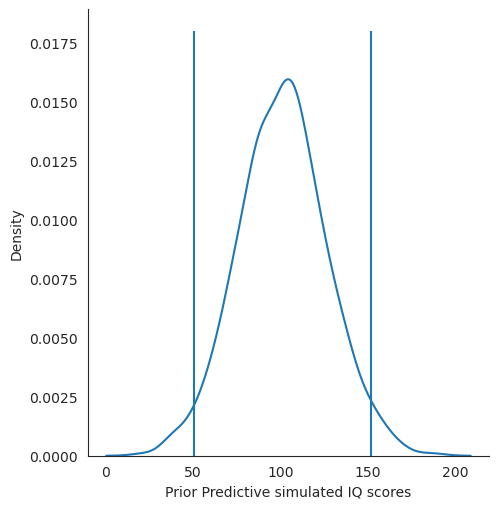

In [8]:
# Following visualisng the prior for the only parameter that will be estimated within the model 
# we can  generate simulated data based on this prior and assumed known standard deviation of 15 for IQ scores.

# Set seed to allow for the reprodcuiblity of notebook.
np.random.seed(1)

# Simulate data from the prior for the mean of the model specified above.
sample_mu = np.random.normal(loc= 100, scale = 20, size = 1000)

# Generate a simulated data set of IQ scores based on the prior for the means and the assumed known Standard deviation (15)
# and the normal likelihood.
prior_PC = np.random.normal(loc = sample_mu, scale = 15, size = 1000)

# Plot the simulated data density
sns.displot(prior_PC, kind="kde");
plt.xlabel("Prior Predictive simulated IQ scores");

# Plot vertical line of the 2 standard deviatons either side of the simulated data.
plt.vlines((np.mean(prior_PC) + 2 * np.std(prior_PC)), ymin=0, ymax=0.018);
plt.vlines((np.mean(prior_PC) - 2 * np.std(prior_PC)), ymin=0, ymax=0.018);

<font size = 3>As the prior predictive check of our priors shows that the simulated data is reasonable within the understanding of IQ, whilst also incorporating reasonable uncertainty for a skeptical audience in that our priors enocde that it is 95% probable to observe individuals with IQ's as low as 50 and as high as 150.</font>

# Step 4 - Use Bayes rule.

The software of choice to conduct Bayesian inference on the data here is Stan and the model is specified below.

# Stan model of a Bayesian Z-test



<font size = 3>Below the statistical model defined above in section 5 of this notebook is coded in Stan code for compilation below</font>

The Stan model above takes the data in the model block, the only parameter in this Z-test equivalent to be estimated is $\large \mu$ and as such is specified in the parameters block. The model itself is then defined in the model block, this is where most of the action happens, and the postersior is estimated using Stan NUTS HMC sampler by taking the prior on $\large \mu$ and the likelihood for the IQ scores data to estimate the posterior.

In [13]:
# To use pystan the data must be stored in a python dictionary that coincides with what was declared in the data
# block of the stan model above, in order, that it can be passed to the compiled stan model for fitting below.

data = {'N': len(IQ),
        'y': IQ,
        'sigma': 15
       }
model_path = "stan/one_z_test_model.stan"
sm = CmdStanModel(stan_file = model_path, cpp_options={'STAN_THREADS': 'TRUE'},
                     force_compile = True)   

10:24:19 - cmdstanpy - INFO - compiling stan file /home/harrison/Desktop/githubrepos/Statistical-methods-for-research-workers-bayes-for-psychologists-and-neuroscientists/Chapter_1_-_Z-test/stan/one_z_test_model.stan to exe file /home/harrison/Desktop/githubrepos/Statistical-methods-for-research-workers-bayes-for-psychologists-and-neuroscientists/Chapter_1_-_Z-test/stan/one_z_test_model
10:24:32 - cmdstanpy - INFO - compiled model executable: /home/harrison/Desktop/githubrepos/Statistical-methods-for-research-workers-bayes-for-psychologists-and-neuroscientists/Chapter_1_-_Z-test/stan/one_z_test_model


In [14]:
write_stan_json("data.json", data = data)

# Fit the One_z_test_model specified above.
fit = sm.sample("data.json", chains = n_chains , iter_sampling=n_samples, iter_warmup = n_warmup, parallel_chains = n_chains, adapt_delta = stepS)

10:27:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 5 |          | 00:00 Status

chain 6 |          | 00:00 Status

chain 7 |          | 00:00 Status

chain 8 |          | 00:00 Status

chain 9 |          | 00:00 Status

chain 10 |          | 00:00 Status

chain 11 |          | 00:00 Status

chain 12 |          | 00:00 Status

chain 13 |          | 00:00 Status

chain 14 |          | 00:00 Status

chain 15 |          | 00:00 Status

chain 16 |          | 00:00 Status

10:27:53 - cmdstanpy - INFO - CmdStan done processing.


In [30]:
# Convert to xarray object.
idata = az.from_cmdstanpy(
    posterior=fit,
    posterior_predictive=['yrep'],
    observed_data={'y': IQ}  # Use a dictionary here
)

In [33]:
az.summary(idata, var_names = ["mu", "diff", "Cohen_D", "mean_pv"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,100.923,1.488,98.301,103.818,0.021,0.015,5193.0,8686.0,1.0
diff,0.923,1.488,-1.699,3.818,0.021,0.015,5193.0,8686.0,1.0
Cohen_D,0.062,0.099,-0.113,0.255,0.001,0.001,5193.0,8686.0,1.0
mean_pv,0.497,0.500,0.000,1.000,0.005,0.004,10027.0,10027.0,1.0


# Post model fit-visualisations - Bayesian one sample Z-test
The arviz package offers many useful functions for plotting MCMC samples of the posteriors produced by Bayesian data analysis with Stan.

## Posterior distributions plots


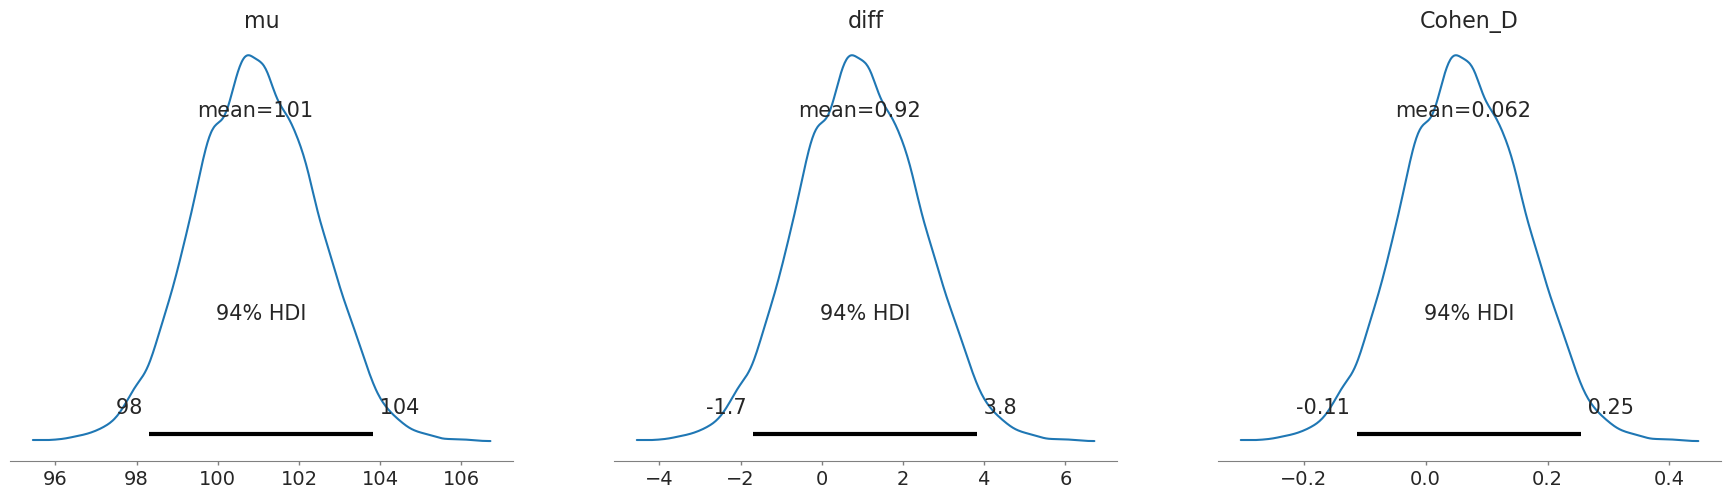

In [34]:
# Using the arviz package the posteriors can be plotted from the MCMC samples
az.plot_posterior(idata, var_names = ["mu", "diff", "Cohen_D"]);

The posterior above shows that the simulated $\large \mu$ of 100 is captured witin the posterior with a posterior mean of 101 and there no statistical difference between the estimate $\large \mu$ and 100 

## Autocorrelation plots

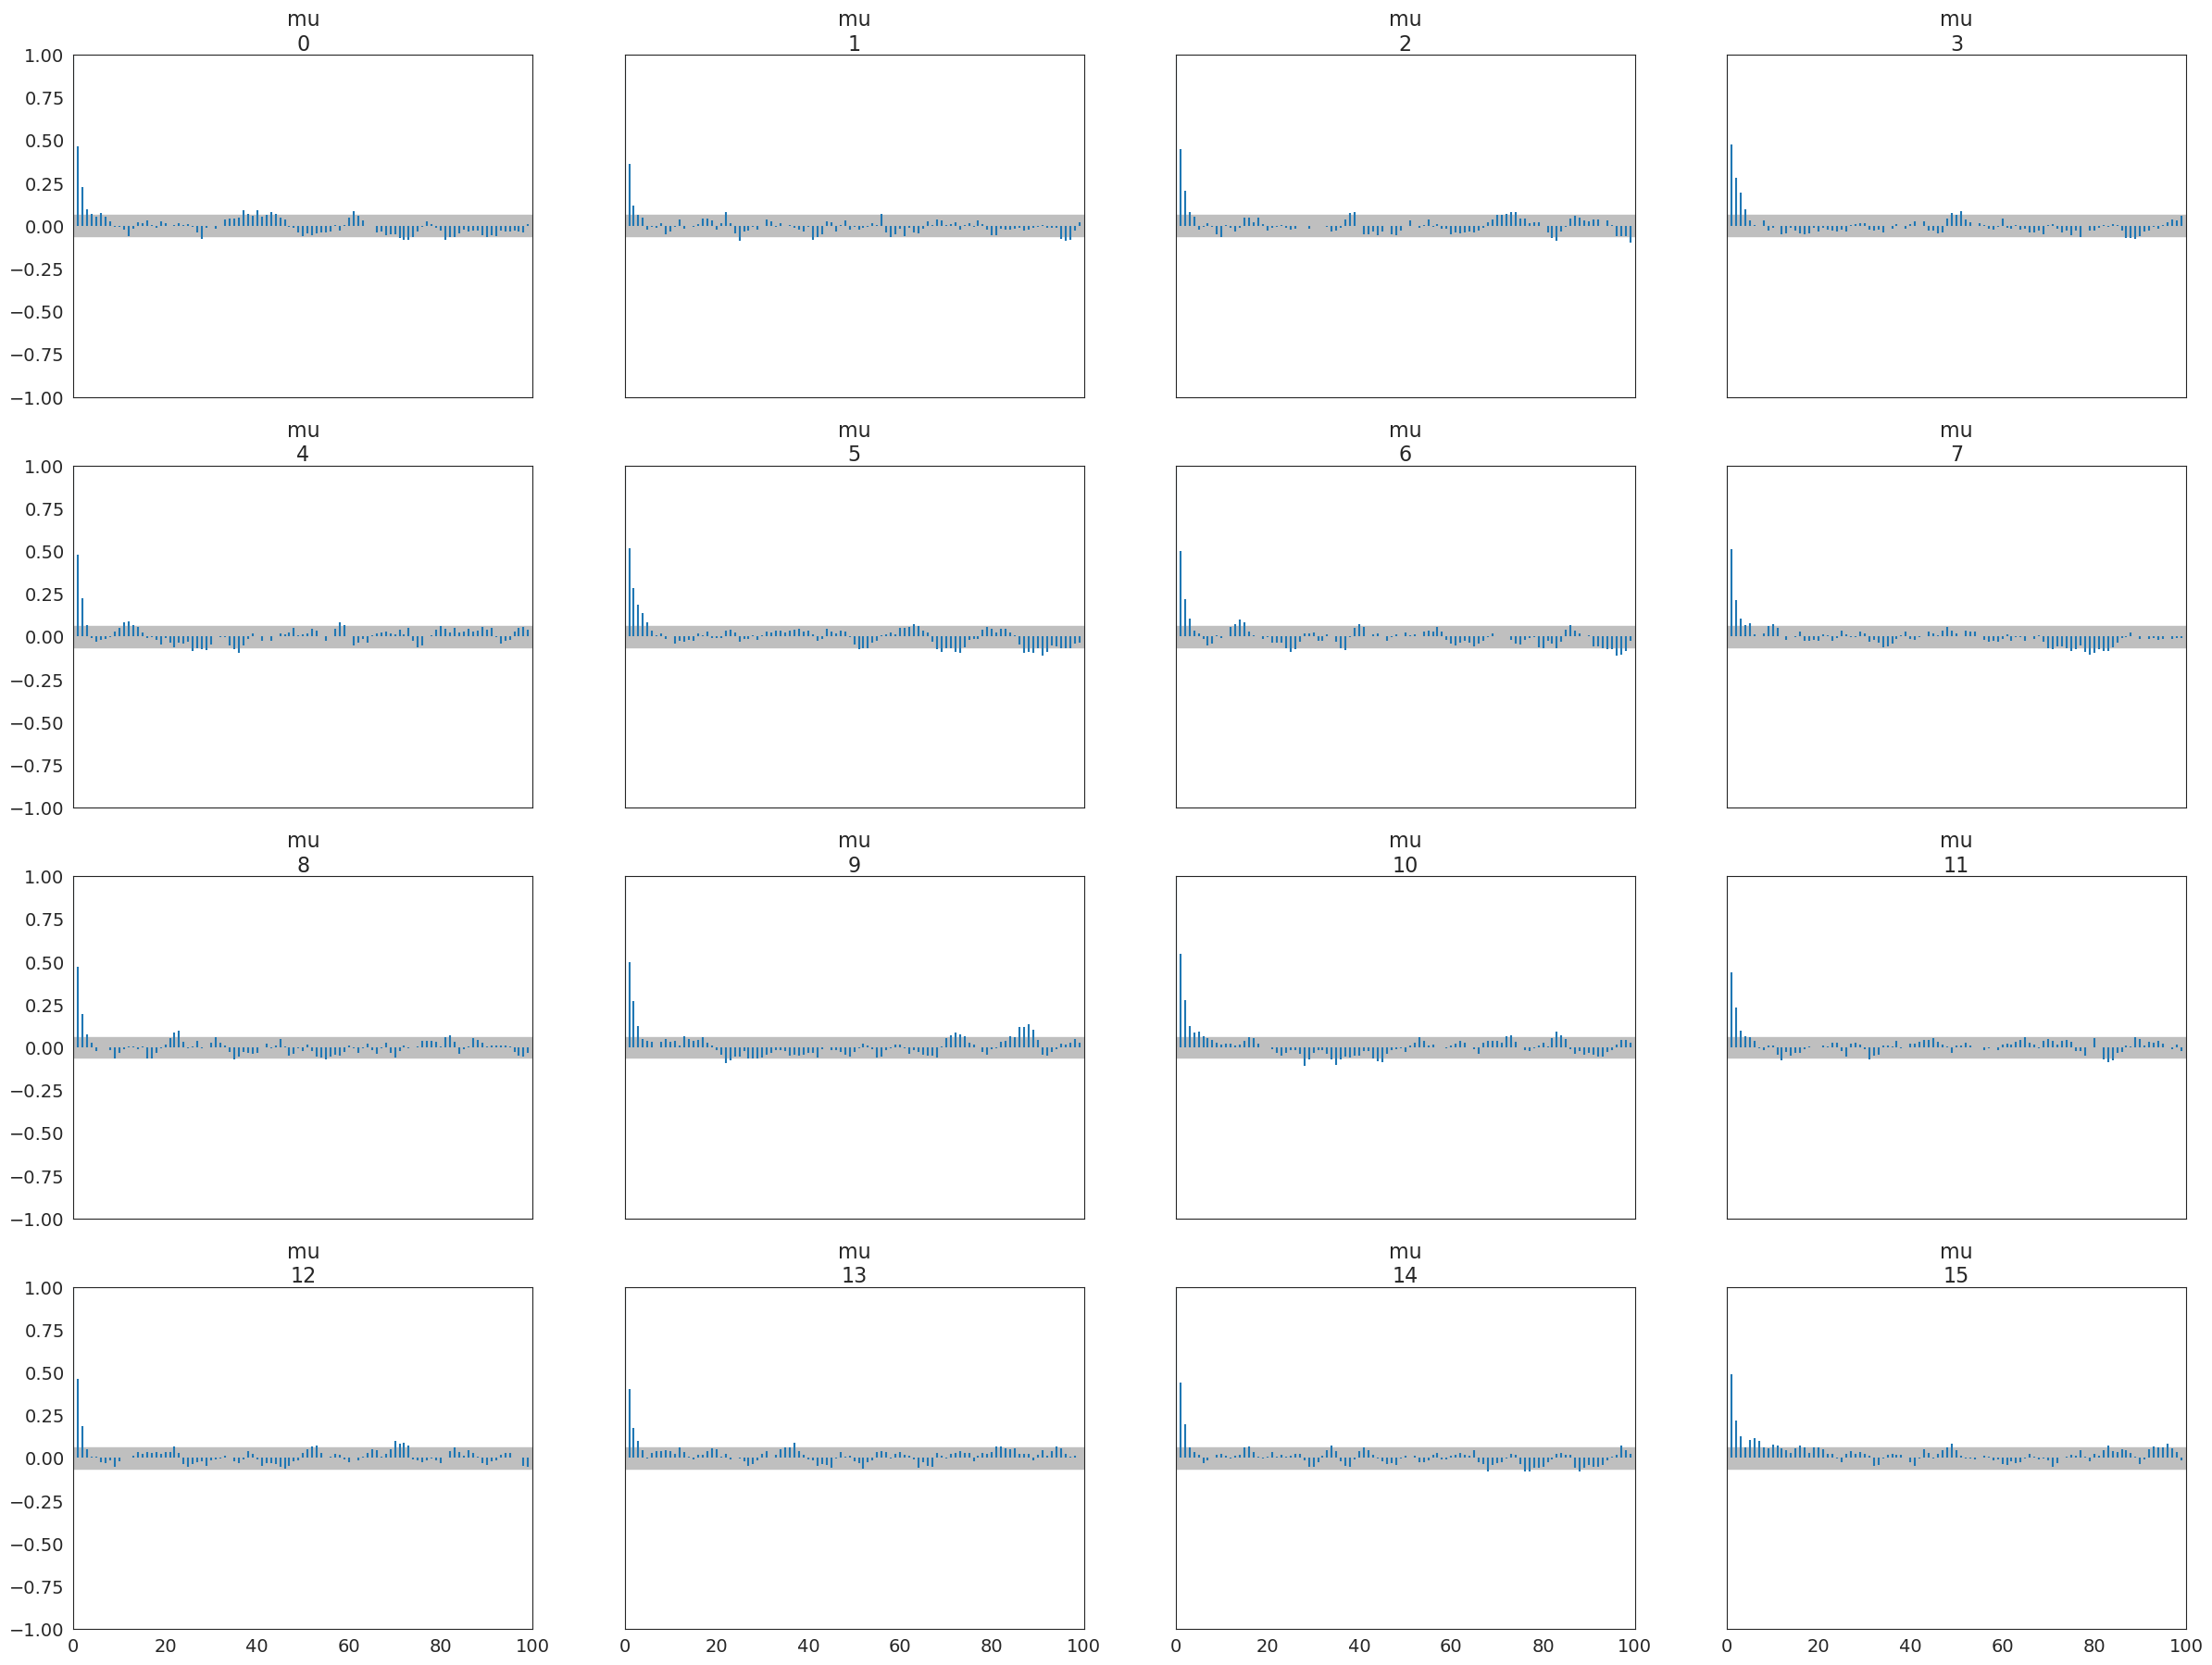

In [35]:
# Using the arviz package the autocorrelation of the 4 MCMC chains can be plotted.
az.plot_autocorr(idata, var_names = ["mu"]);

The autocorrelation plots do not show any serious autocorrelation problems, as the values quickly decrease to 0.

## MCMC traceplots

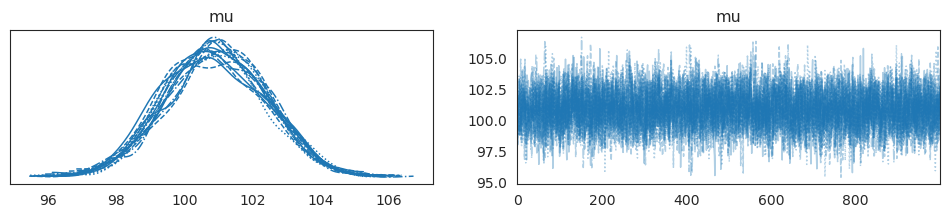

In [36]:
# Using the arviz package the traceplots of the 4 MCMC chains can be plotted.
az.plot_trace(idata, var_names = ["mu"]);

The traceplots do not show an visual pathologies show good mixing of chains and show a "hairy catepillar".

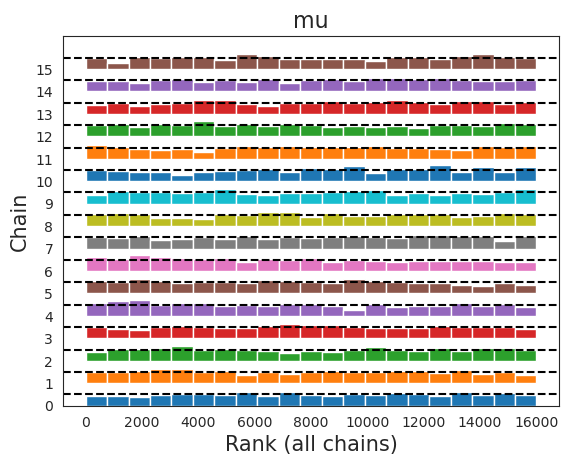

In [37]:
az.plot_rank(idata, var_names = ["mu"]);

# Step 5 - Posterior predictive checks

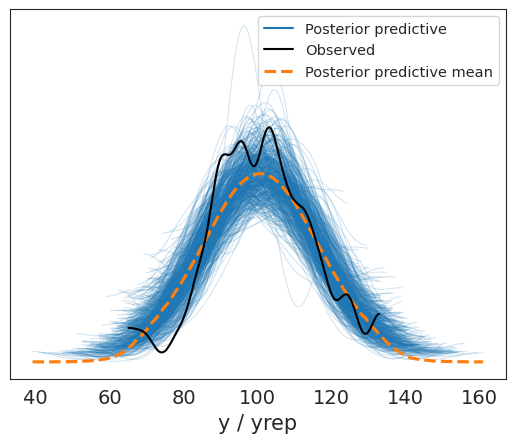

In [38]:
az.plot_ppc(data = idata, data_pairs = {'y': 'yrep'}, num_pp_samples = 500);

The posterior samples show that the simulated datasets can capture the orignal data well.

# Reporting the results of the Bayesian one sample Z-test equivalent

<font size = "3">As Kruscke (2015) correctly points out there is not standard formula or presentation method for presenting the results from Bayesian data analyis in journal article like the APA guide for reporting frequentist analysis. It is likely there never will be, because as McElreath (2020) explains Bayesian data analysis is more like a engineering approach to the problem and the resulting model that is fit will be analysis specific. In addition, as Gabry et al, (2017) argue visualisations maybe even more key so the all the visualistions above would have to be included with any write up. Anyway,  the write up below generally follows the advice of Kruscke (2015) chapter 25. In any application though it comes down to the problem to be described and satidying the audience of the work. </p><br/>

<h2>Write up of One sample Z-test</h2><br/>

<font size = "3"> Four chains were ran with 2000 MCMC samples each disaring the first 1000 warm up samples. The data was analsyed using the model described above with the $\mu$ being the only model parameter estimated with a normal prior with a $\mu = 100$ and  $\sigma =20$. The standard deviation of the normal likelihood was modelled as known at a value of 15. Prior predcitve checks revealed that these values were uninfomative giving high porbaility to a large range of values for the IQ scores.
    
Convergence of the MCMC chains was examined using autocorrelation and traceplots (in a paper referncing appropriate figures here will be of value). The posteriors showed that the most credible value of $\mu$ = 100.88 with a 95% CrI [97.94, 103.78]) for the IQ scores under the model used in the analysis. Posterior predctive checks revelaed that the model could also reasonable recover the orignal data of the two groups. </font>

==========================================================================================================================

# Bayesian estimation equivalent of the two sample Z-test
Below the model will be extended to estimate two groups in a classical z-test Bayesian estimation equivalent

# Step 1 - Identify the relevant data for the question under investigation.

## Simulate a second group of data
For the analsyis below we need to simulate a second group of IQ scores.

In [40]:
# Set seed for reproducible notebook
np.random.seed(1)

# Simulation seocnd group of 100 Independent IQ scores from a normal distribtuion but this
#time with a mean of 110 and Standard deviation of 15
IQ_2 = np.round(np.random.normal(loc = 110, scale = 15, size = 100))

## Visualise and explore the data

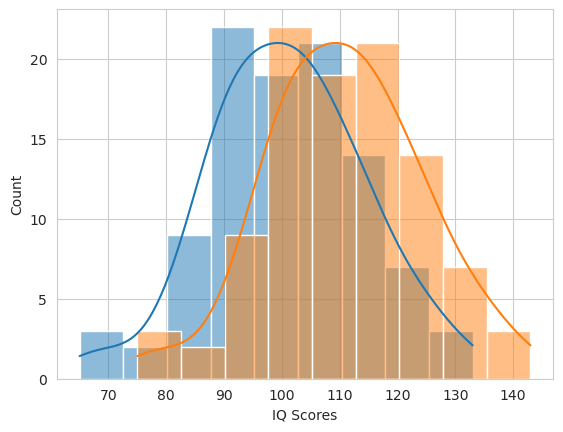

In [41]:
# Set Seaborn theme for data visualisations.
sns.set_style("whitegrid")

# Plot a histogram of the first group IQ data with a normal distribution imposed.
sns.histplot(IQ, kde= True);
plt.xlabel("IQ Scores");

# Plot a histogram of the first group IQ data with a normal distribution imposed.
sns.histplot(IQ_2, kde= True);
plt.xlabel("IQ Scores");

\begin{align*}
y_{ik} &\sim \text{Normal}(\mu_{k}, 15) \\
\mu_{k} &\sim \text{Normal}(100, 20)
\end{align*}

The model above, in plain English, states that the dependent variable (IQ) for the $k$ groups (two in this case) is distributed normally. The prior specifies that the mean ($\mu$) for IQ is normally distributed with a mean of 100, indicating that an IQ of 100 is the most probable value, with a standard deviation of 20.

\small{Note to the reader: In this model, the prior is constructed so that it is the same for both $\mu$ estimations for the separate groups. However, this is not a necessity, and separate priors can be set if desired.}

# Step 3 - Prior predictive checks
as the model priors are the same as above for both groups for PPC see section 6 above

# Step 4 - Use Bayes rule.
<font size = 3>Below the statistical model defined above in section  of this notebook is coded in Stan code for compilation below</font>

In [46]:
# Generate a python dictionary for passing to pass Stan for fitting the model above.
data_2 = {'N': len(IQ),
          'y_1': IQ,
          'y_2': IQ_2,
          'sigma': 15}


model_path = "stan/two_z_test_model.stan"
# Compile stan model into C++ code
sm_2 = CmdStanModel(stan_file = model_path, cpp_options={'STAN_THREADS': 'TRUE'},
                     force_compile = False)   

In [48]:
write_stan_json("data2.json", data = data_2)

# Fit two sample z-test model to the data.
fit_2 = sm_2.sample("data2.json", chains = n_chains , iter_sampling=n_samples, iter_warmup = n_warmup, parallel_chains = n_chains, adapt_delta = stepS)

10:46:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 5 |          | 00:00 Status

chain 6 |          | 00:00 Status

chain 7 |          | 00:00 Status

chain 8 |          | 00:00 Status

chain 9 |          | 00:00 Status

chain 10 |          | 00:00 Status

chain 11 |          | 00:00 Status

chain 12 |          | 00:00 Status

chain 13 |          | 00:00 Status

chain 14 |          | 00:00 Status

chain 15 |          | 00:00 Status

chain 16 |          | 00:00 Status

10:46:36 - cmdstanpy - INFO - CmdStan done processing.


In [76]:
# Convert to xarray object.
idata2 = az.from_cmdstanpy(
    posterior=fit_2,
    posterior_predictive=["y1rep", "y2rep"],
    observed_data={"y_1": IQ,
                   "y_2": IQ_2} 
)

In [52]:
# Generate summary table for the parameters and generated quantities.
az.summary(idata2, var_names = ["mu_1", "mu_2", "diff", "Cohen_D"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_1,100.948,1.487,98.225,103.817,0.013,0.009,13357.0,10690.0,1.0
mu_2,110.895,1.486,108.028,113.624,0.013,0.009,13557.0,10592.0,1.0
diff,-9.947,2.091,-13.878,-6.035,0.018,0.013,13466.0,10487.0,1.0
Cohen_D,-0.663,0.139,-0.925,-0.402,0.001,0.001,13466.0,10487.0,1.0


# Post model fit visualisations - Bayesian two sample Z-test

## Posterior distribution plots

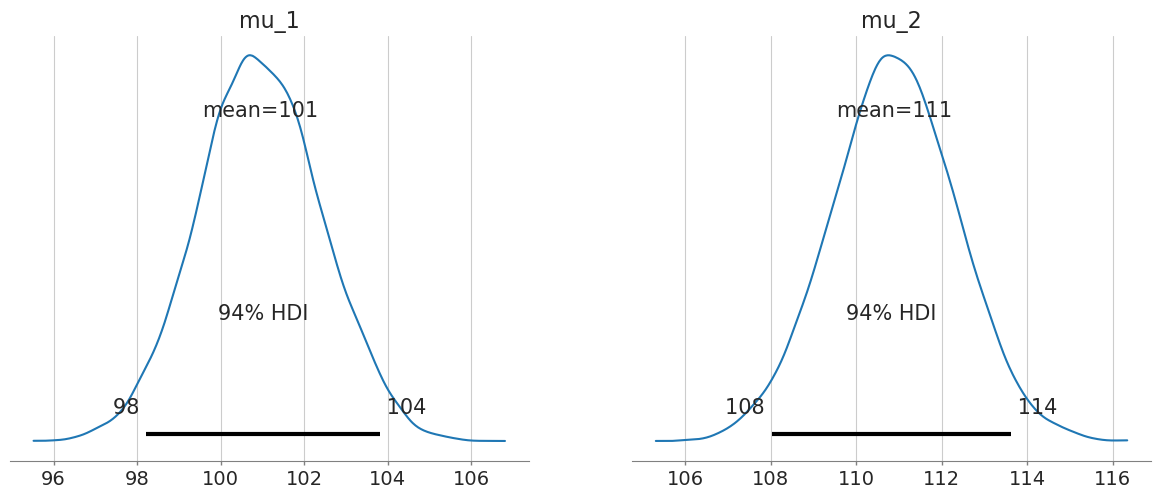

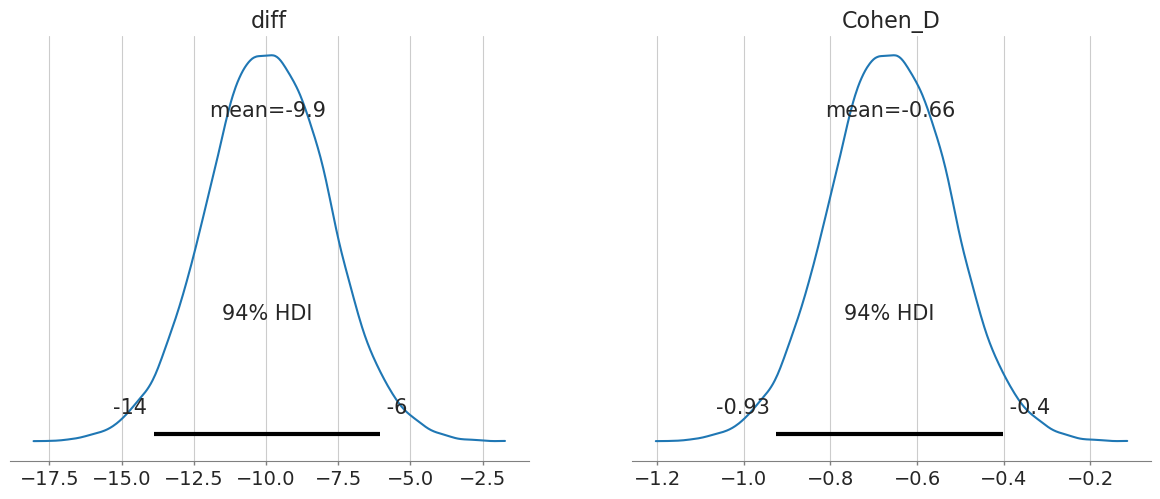

In [53]:
# Using the arviz package the posteriors can be plotted from the MCMC samples 
az.plot_posterior(idata2, var_names=("mu_1", "mu_2" ));
az.plot_posterior(idata2, var_names=("diff", "Cohen_D" ));

## Autocorrelation plots

/home/harrison/miniconda3/envs/stan/lib/python3.13/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (64) in plot_autocorr, generating only 40 plots
  warnings.warn(


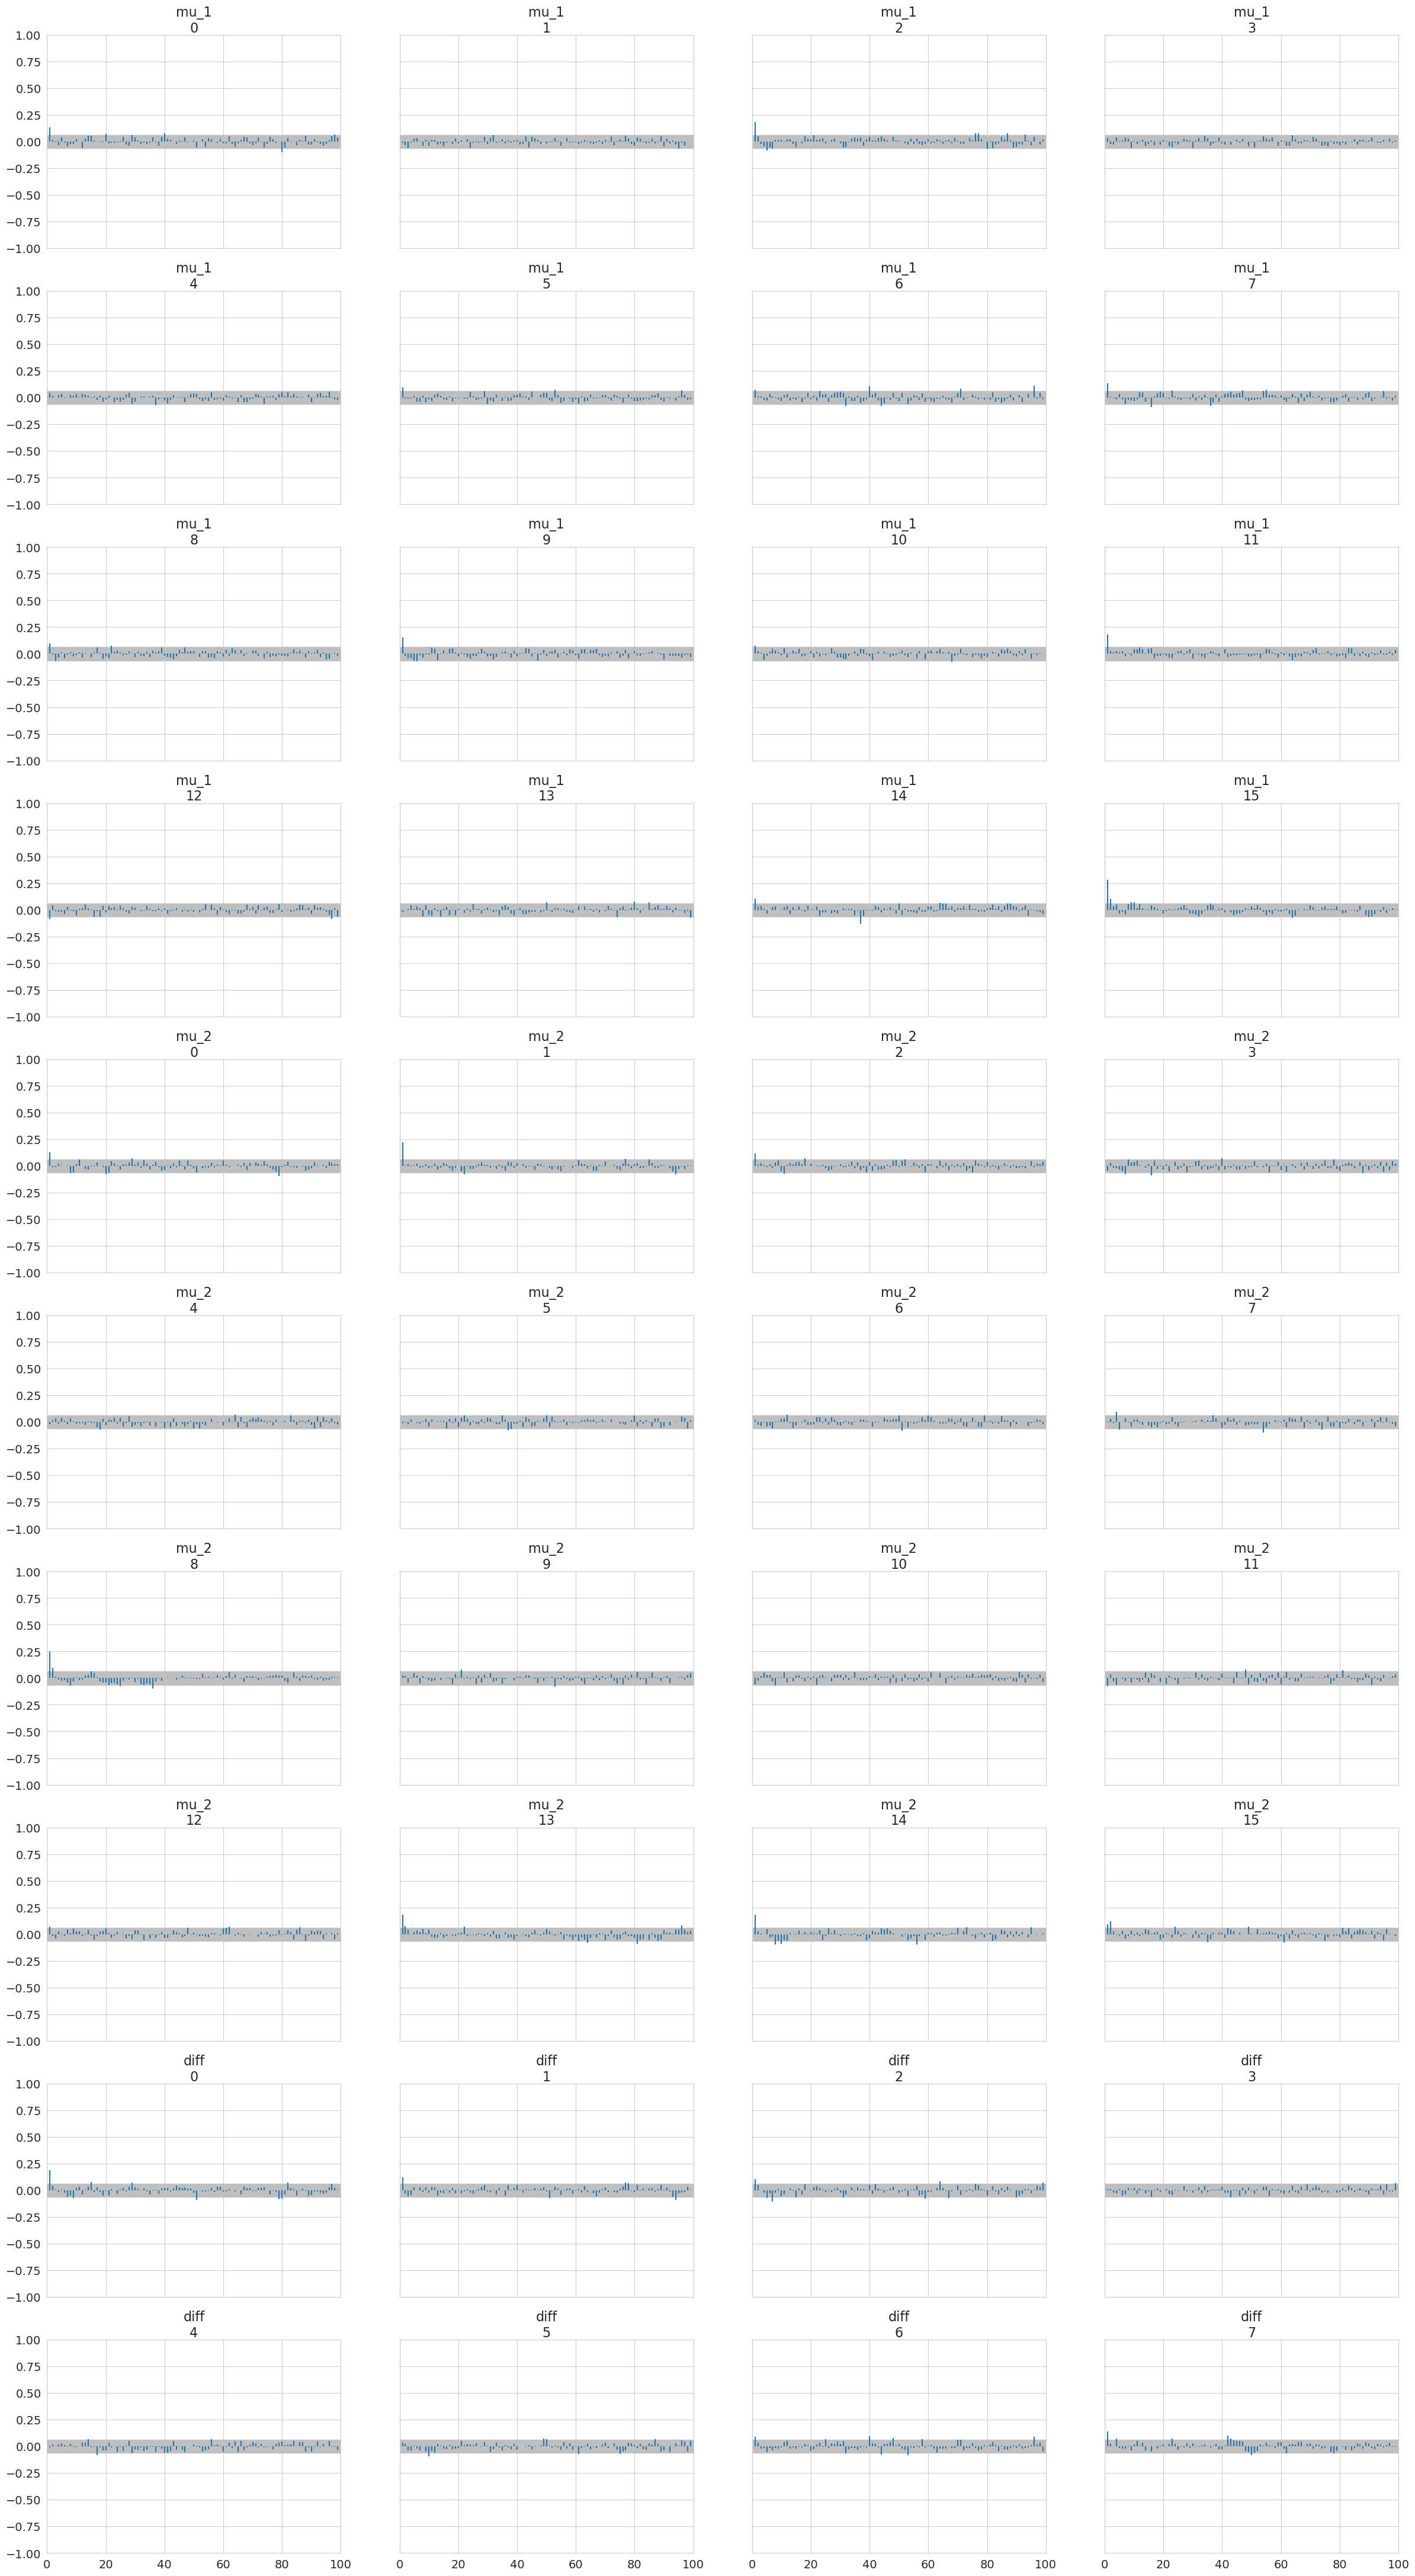

In [77]:
# Use arvix to generate autocorrelation plots for MCMC chains.
az.plot_autocorr(idata2, var_names = ["mu_1", "mu_2", "diff", "Cohen_D"]);

Autocorrelation plots show little issue in terms of autocorreltion with the values centered around 0.

## MCMC Traceplots

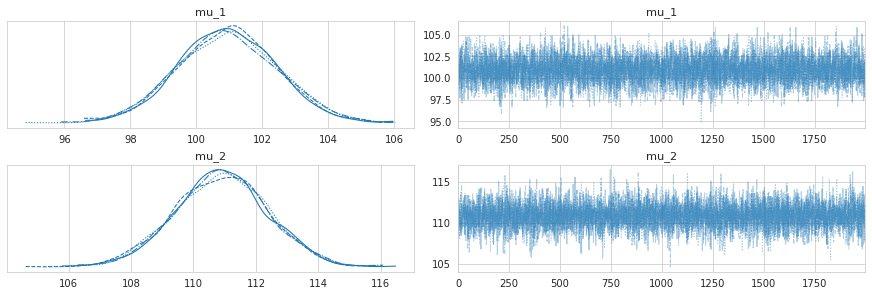

In [26]:
az.plot_trace(fit_2, var_names = ["mu_1", "mu_2"]);

Traceplots show good mixing of the Markow chains and show a hairy catepillar.

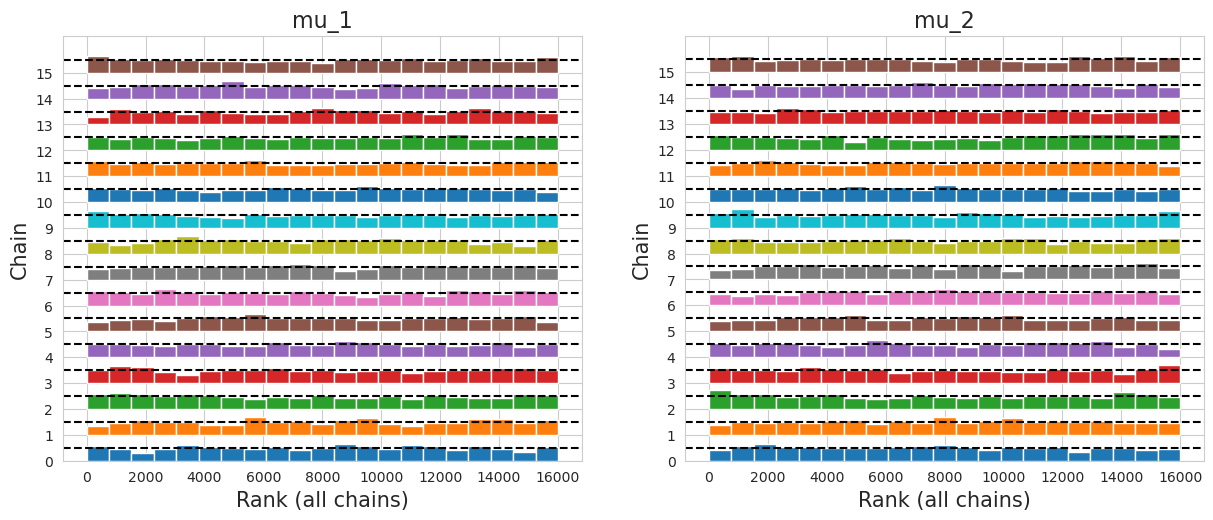

In [55]:
az.plot_rank(idata2, var_names = ["mu_1", "mu_2"]);

Rank plots show good results with little disturbance from uniform distributions.

# Step 5 - Posterior predictive check - two groups

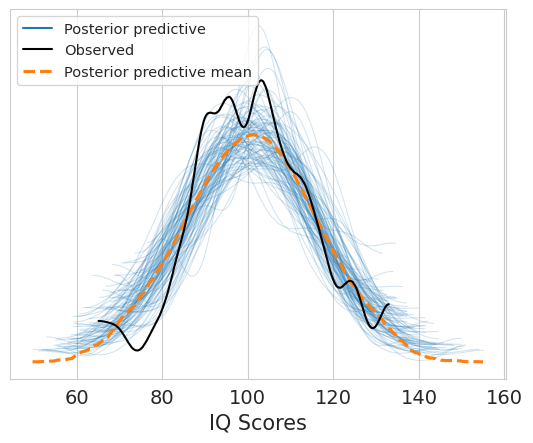

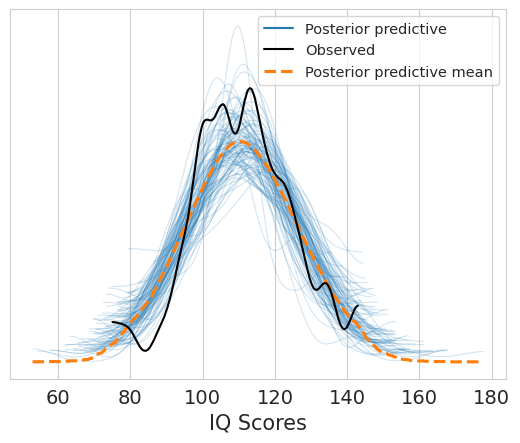

In [94]:
idata2 = az.from_cmdstanpy(
    posterior=fit_2,
    posterior_predictive=["y1rep"],
    observed_data={"y_1": IQ} 
)               

az.plot_ppc(idata2, data_pairs = {"y_1" : "y1rep"}, num_pp_samples = 100);
plt.xlabel("IQ Scores");
 
idata2 = az.from_cmdstanpy(
    posterior=fit_2,
    posterior_predictive=["y2rep"],
    observed_data={"y_2": IQ_2} 
)           
az.plot_ppc(idata2, data_pairs = {"y_2" : "y2rep"}, num_pp_samples = 100);
plt.xlabel("IQ Scores");


# Reporting the results of the two sample Z-test
see section for reporting one sample z-test in this notebook above for brief discussion on the lack of clarity in reporting Bayesian analyses.

## Write up of two sample Z-test

<font size = "3"> The IQ data for the two groups were analsyed using the model defined above with the $\mu$ being the only model parameter to be estimated for each of the two groups, each with a normal prior with a $\mu = 100$ and  $\sigma =20$. The standard deviation of the normal likelihood of each group was modelled as known at a value of 15. Prior predcitve checks revealed that these values were uninformative give high probability to a large range of values for the IQ scores.
    
The MCMC chains were ran to acquire 2000 samples wiht the first 1000 samples being for warm up. Convergence of the MCMC chains was examined using autocorrelation and traceplots (in a paper referncing appropriate figures here will be of value). Both sets of plots showed no issues of autocorrelation or lack of mixing for the chains. The posteriors showed that the most credible values for group one was $\mu$ = 101 with a 95% CrI [98, 104]) and $\mu$ = 111 with a 95% CrI [108, 114]) for group two of for the IQ scores under the model used in the analysis. Anasyis of the unstandarsised differnce between the two groups showed credidle values of  $\mu$ = -10 with a 95% CrI [-14, -6]). For the standardised Cohen D scores credible values of $\mu$ = -.67 with a 95% CrI [-.95, -.38]) were found.

Finally, the posterior predctive checks revealed that the model could also reasonable recover the orignal data. </font>

# <center> References </center>

Gabry, J., Simpson, D., Vehtari, A., Betancourt, M., & Gelman, A. (2019). Visualization in Bayesian workflow. Journal of the Royal Statistical Society: Series A (Statistics in Society), 182(2), 389-402.
    
Kruschke, J. (2015). Doing Bayesian data analysis: A tutorial with R, JAGS and Stan. Oxford, England: Academic Press.    
    
McElreath, R. (2020). Statistical rethinking: A Bayesian course with examples in R and Stan. Boca Raton: CRC Press.

Warne, R., T. (2020). In the know: Debunking 35 myths about human intelligence. New york, NY: Cambridge University Press.